In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk',
    palette='Set1'
)

/Users/noa/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[![scikit-learn logo](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)](http://scikit-learn.org/)

*Scikit-learn* is a Python package for **machine learning**:


- Simple and efficient tools for data mining and data analysis
- Accessible to everybody, and reusable in various contexts
- Built on NumPy, SciPy, and matplotlib
- Open source, commercially usable - BSD license

We will do [one of the many tutorials](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html) from the *scikit-learn* website. 

You can install *scikit-learn* with `conda install scikit-learn`.

## Supervised learning: predicting an output variable from high-dimensional observations

Supervised learning consists in learning the link between two datasets: the observed data `X` and an external variable `y` that we are trying to predict, usually called “target” or “labels”. Most often, `y` is a 1D array of length `n_samples`.

All supervised estimators in *scikit-learn* implement a `fit(X, y)` method to fit the model and a `predict(X)` method that, given unlabeled observations `X`, returns the predicted labels `y`.

## Possum dataset

The [Possum dataset](https://www.kaggle.com/datasets/abrambeyer/openintro-possum) comprises nine morphometric measurements for each of the 104 mountain brushtail possums captured at seven locations spanning from Southern Victoria to central Queensland.  

<img src="https://storage.googleapis.com/kaggle-datasets-images/1534513/2532158/c49c3c89019ed2251376ecfcf7a7eec0/dataset-cover.jpg?t=2021-08-17-01-33-40" width="200"/>

Let's start by loading the dataset.

In [2]:
filename = '../data/possum.csv'
possum_data = pd.read_csv(filename)
possum_data.head()

,case,site,Pop,sex,age,hdlngth,skullw,totlngth,taill,footlgth,earconch,eye,chest,belly
0,1,1,Vic,m,8.0,94.1,60.4,89.0,36.0,74.5,54.5,15.2,28.0,36.0
1,2,1,Vic,f,6.0,92.5,57.6,91.5,36.5,72.5,51.2,16.0,28.5,33.0
2,3,1,Vic,f,6.0,94.0,60.0,95.5,39.0,75.4,51.9,15.5,30.0,34.0
3,4,1,Vic,f,6.0,93.2,57.1,92.0,38.0,76.1,52.2,15.2,28.0,34.0
4,5,1,Vic,f,2.0,91.5,56.3,85.5,36.0,71.0,53.2,15.1,28.5,33.0


## Data visualization

Data visualization is an important step before applying machine-learning models.

Let's use the pandas `pd.plotting.scatter_matrix` to draw a matrix of scatter plotss between head length(hdlngth), total length and tail length, and sex.

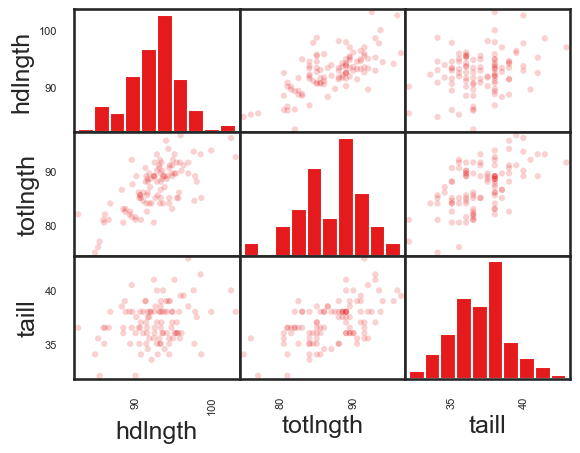

In [13]:
pd.plotting.scatter_matrix(possum_data[['hdlngth','totlngth','taill','sex']], alpha=0.2);

In [23]:
print(possum_data.isnull().any())

case        False
site        False
Pop         False
sex         False
age          True
hdlngth     False
skullw      False
totlngth    False
taill       False
footlgth     True
earconch    False
eye         False
chest       False
belly       False
dtype: bool


As expected, the head length(hdlngth), total length and tail length are all positively correlaed.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X = possum_data.drop(columns = ['case','site','Pop','sex'])
y = possum_data['hdlngth']
x_train, x_test,y_train,y_test = train_test_split(X,y,test_size =0.2)
clf = LinearRegression()
clf.fit(x_train,y_train)
#clf.predict(x_test)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').